# Data Dimensionality
As for tabular data, the first thing to understand is the data dimensionality. In the case of a single time series, it's simple - we are in the presence of one single dimension. But usually, in this context, dimensionality corresponds to the number of observations taken, which corresponds to the length of the series.
So after loading the data, the usual procedure is to plot the data at the most atomic granularity to look for regularities (repetitions) in the data.

In [149]:
from pandas import read_csv
import matplotlib.pyplot as plt
from ts_functions import plot_series, HEIGHT
import ds_charts as ds
from numpy import ones
from pandas import Series
import pandas as pd

%run p00_settings.ipynb

data = read_csv(project_path + data_file, sep=',', decimal='.', parse_dates=True, infer_datetime_format=True)
data[time_var] = pd.to_datetime(data[['year', 'month', 'day', 'hour']])
data.set_index(time_var, inplace=True)

print(f'Nr. Records = {data.shape[0]}')
print(f'First date: {data.index[0]}')
print(f'Last date: {data.index[-1]}')

Nr. Records = 35064
First date: 2013-03-01 00:00:00
Last date: 2017-02-28 23:00:00


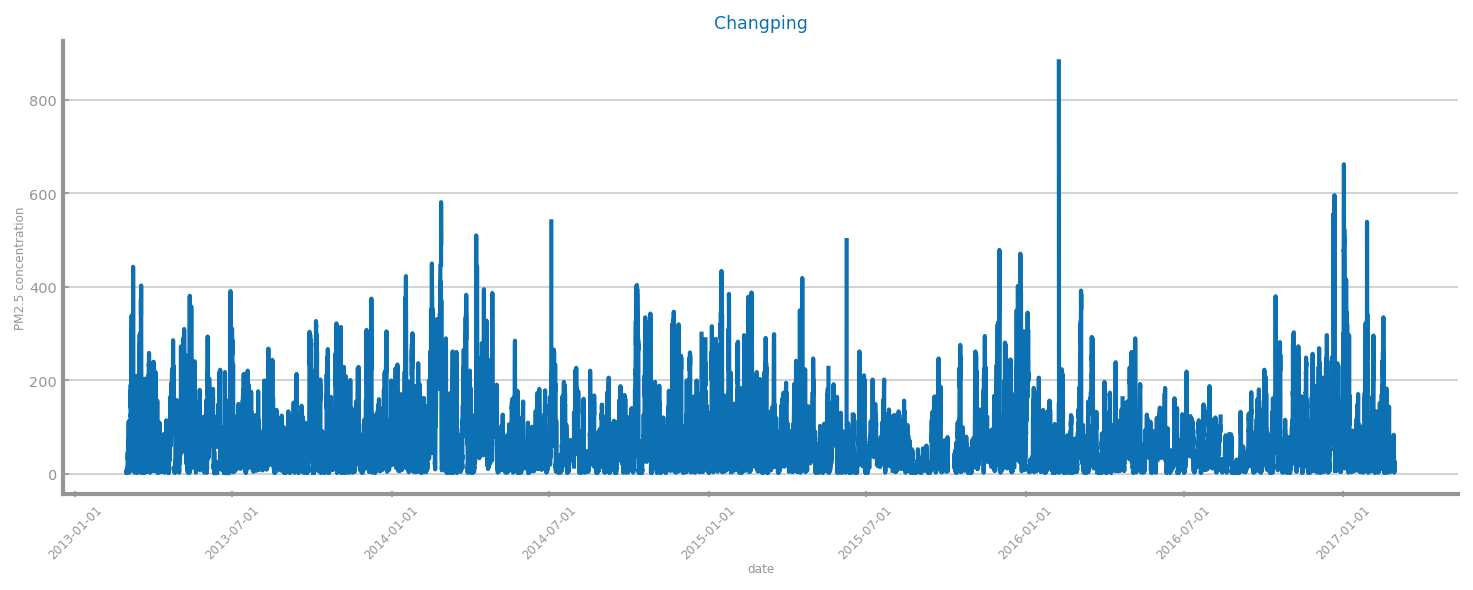

In [150]:
plt.figure(figsize=(3*HEIGHT, HEIGHT))
plot_series(data[target], x_label='date', y_label='PM2.5 concentration', title='Changping')
plt.xticks(rotation = 45)
plt.show()

The plot shows the PM2.5 particles concentration as an indicator of air polution in Changpin.
There some interesting things we can see from looking at the chart:

- first, there appears to be a cyclic behaviour, with higher concentration of PM2.5 particles in the beggining/end of the year.
- second, the series does not seem stationary, due to its mean varying across time, as variance also seems to vary.
- third, the series seems to present some spikes well spaced out between themselves.

# Data Granularity


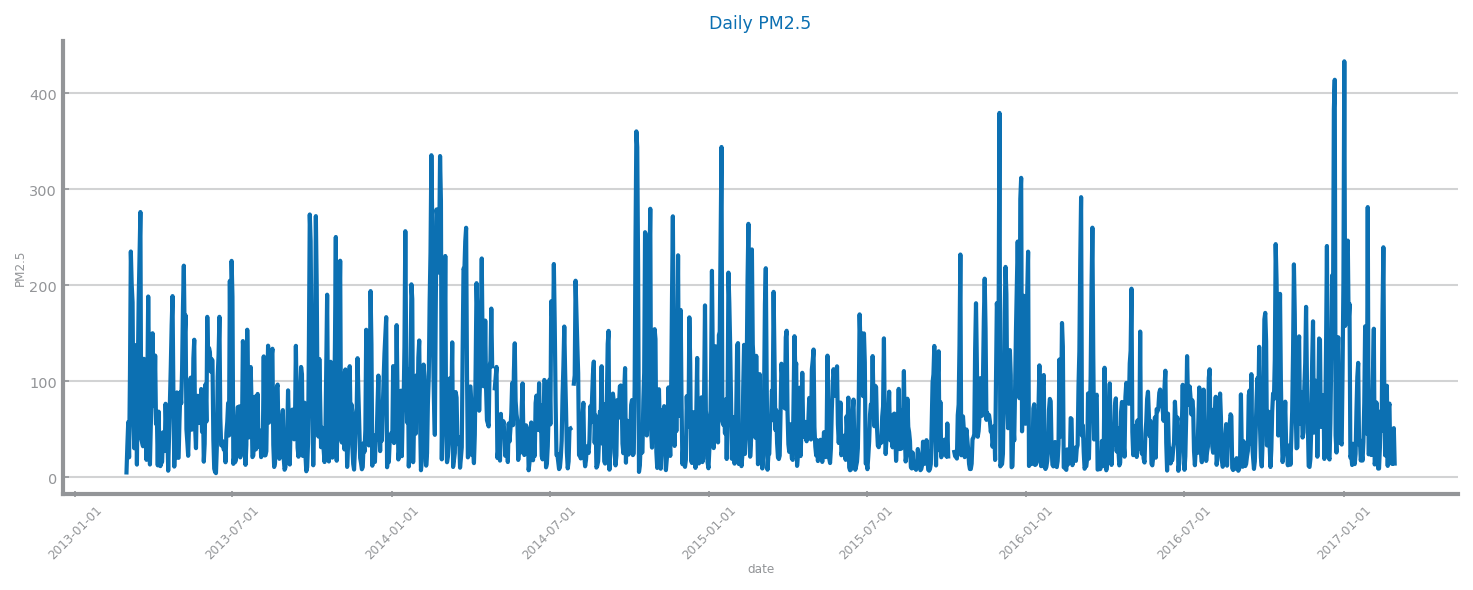

In [144]:
day_df = data.copy().groupby(data.index.date).mean()
plt.figure(figsize=(3*HEIGHT, HEIGHT))
plot_series(day_df[target], title='Daily PM2.5 concentration', x_label='date', y_label='PM2.5 concentration')
plt.xticks(rotation = 45)
plt.show()

Aggregating by days, we perform a kind of a smoothing, since we are using the mean as aggregation function. And as a result, we found a smoother version of the original time series, whith less noise.

In this new version, we continue to identify a cyclic behavior, which seems to be shown yearly (according to the seasons).

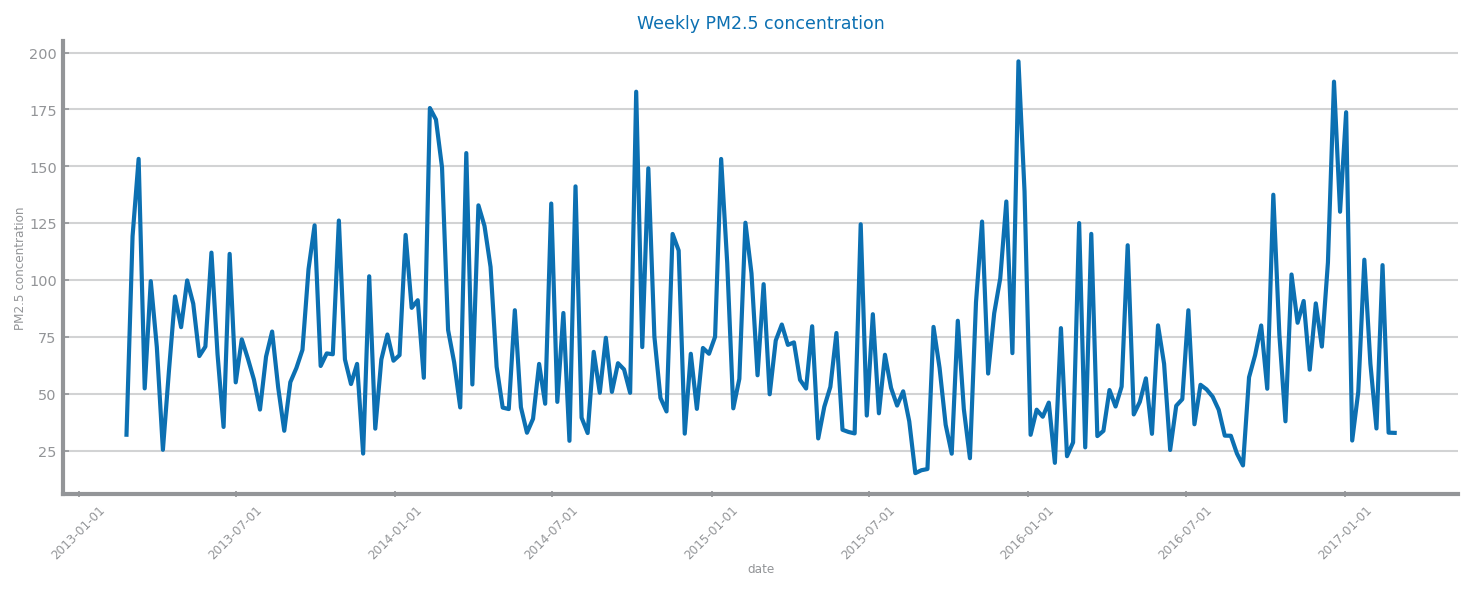

In [151]:
index = data.index.to_period('W')
week_df = data.copy().groupby(index).mean()

week_df['date'] = index.drop_duplicates().to_timestamp()
week_df.set_index('date', drop=True, inplace=True)

plt.figure(figsize=(3*HEIGHT, HEIGHT))
plot_series(week_df[target], title='Weekly PM2.5 concentration', x_label='date', y_label='PM2.5 concentration')
plt.xticks(rotation = 45)
plt.show()

The chart for weekly PM2.5 concentration seems to be less cyclical and more stationary, although spikes tend to occur still in the begginning of each year.

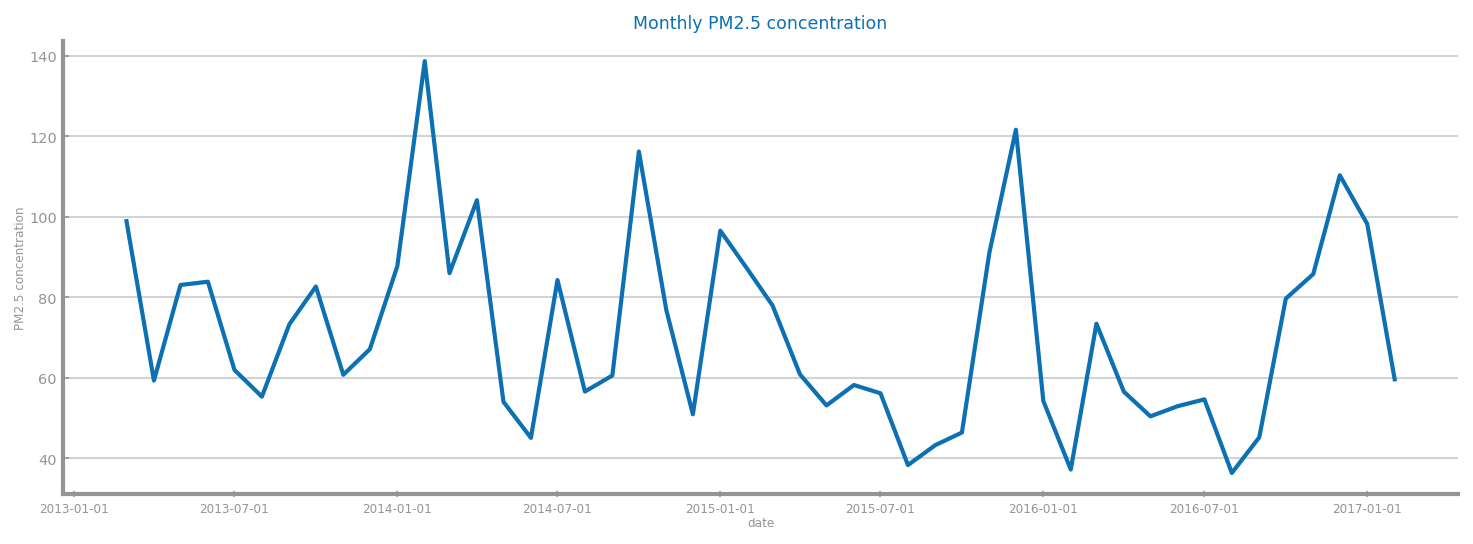

In [152]:
index = data.index.to_period('M')
month_df = data.copy().groupby(index).mean()
month_df['date'] = index.drop_duplicates().to_timestamp()
month_df.set_index('date', drop=True, inplace=True)
plt.figure(figsize=(3*HEIGHT, HEIGHT))
plot_series(month_df[target], title='Monthly PM2.5 concentration', x_label='date', y_label='PM2.5 concentration')
plt.show()

The series seems now even more stationary, although the spikes are now more spaced out, we still observe more preponderance in the beggining of each year.

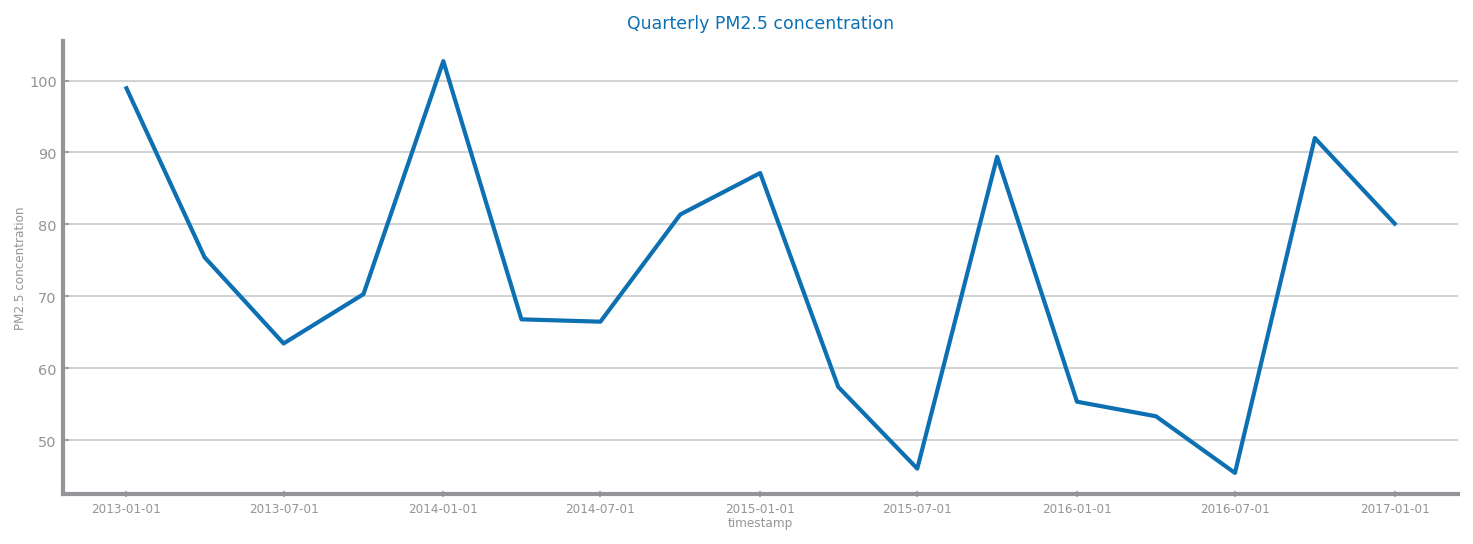

In [155]:
index = data.index.to_period('Q')
quarter_df = data.copy().groupby(index).mean()
quarter_df['date'] = index.drop_duplicates().to_timestamp()
quarter_df.set_index('date', drop=True, inplace=True)
plt.figure(figsize=(3*HEIGHT, HEIGHT))
plot_series(quarter_df[target], title='Quarterly PM2.5 concentration', x_label='timestamp', y_label='PM2.5 concentration')
plt.show()

We now still observe cyclicality, but not always in the first quarter.

Jointly with the last chart, they confirm any suspicion about the lack of stationarity in the time series. Indeed its mean is not constant along time. In particular we identify very different values of PM2.5 concentration per quarter.

# Data Distribution
Like for tabular data, one of the perspectives of analysis to consider is the distribution of data, in particular the centrality, trends and distribution of the variable. But be aware that the different aggregations may show different distributions.

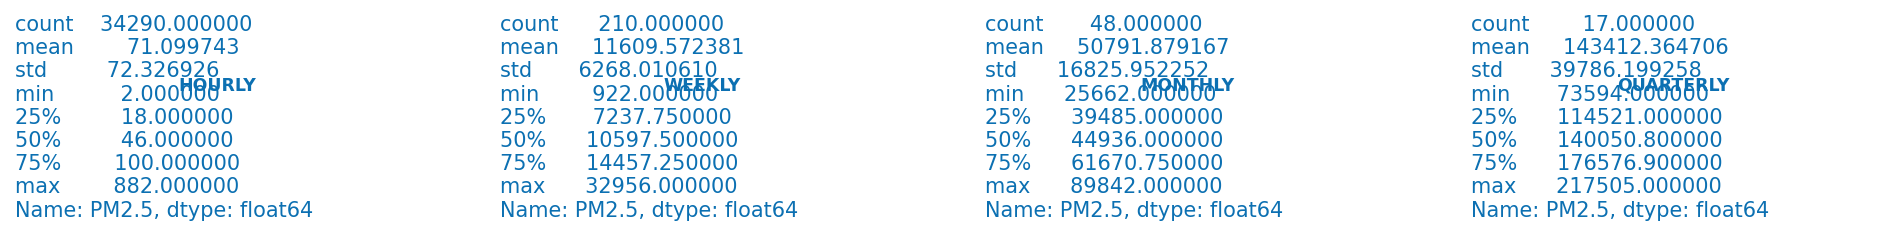

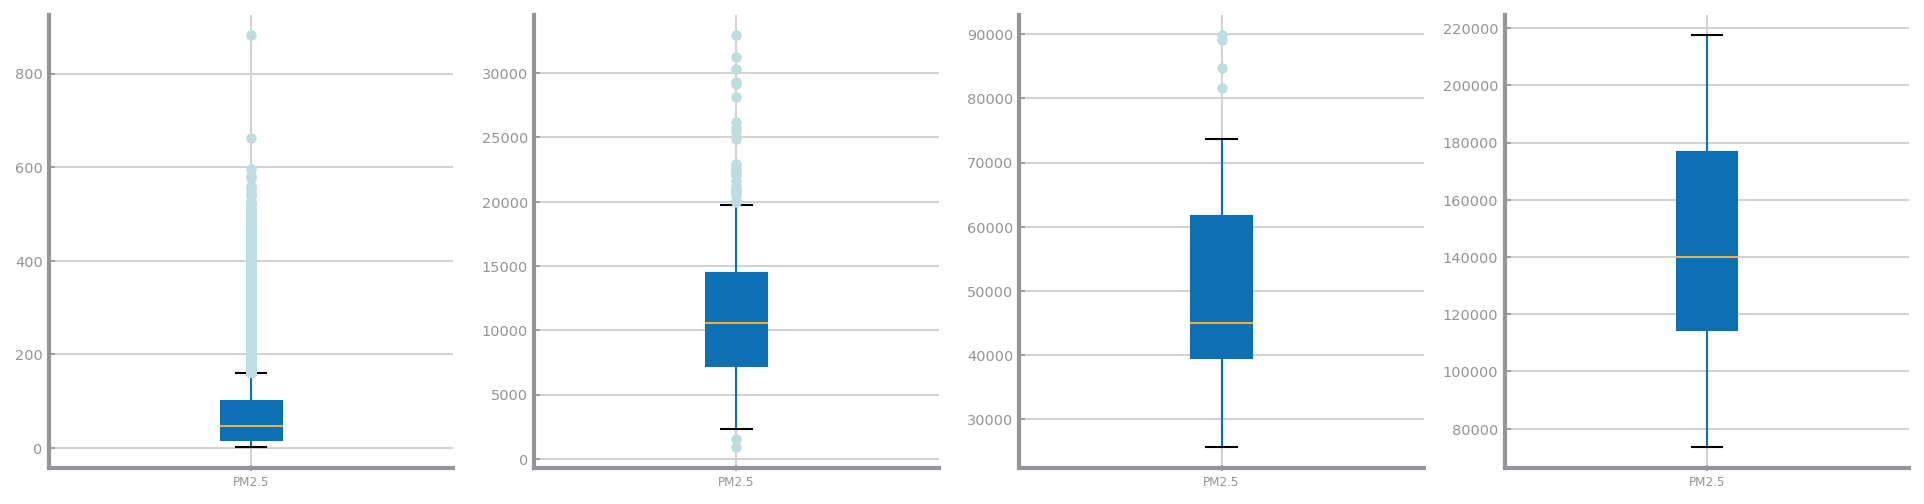

In [162]:
w_index = data.index.to_period('W')
week_df = data.copy().groupby(w_index).sum()
week_df['date'] = w_index.drop_duplicates().to_timestamp()
week_df.set_index('date', drop=True, inplace=True)

m_index = data.index.to_period('M')
month_df = data.copy().groupby(m_index).sum()
month_df['date'] = m_index.drop_duplicates().to_timestamp()
month_df.set_index('date', drop=True, inplace=True)

q_index = data.index.to_period('Q')
quarter_df = data.copy().groupby(q_index).sum()
quarter_df['date'] = q_index.drop_duplicates().to_timestamp()
quarter_df.set_index('date', drop=True, inplace=True)

_, axs = plt.subplots(1, 4, figsize=(4*HEIGHT, HEIGHT/4))

axs[0].grid(False)
axs[0].set_axis_off()
axs[0].set_title('HOURLY', fontweight="bold")
axs[0].text(0, 0, str(data[target].describe()))

axs[1].grid(False)
axs[1].set_axis_off()
axs[1].set_title('WEEKLY', fontweight="bold")
axs[1].text(0, 0, str(week_df[target].describe()))

axs[2].grid(False)
axs[2].set_axis_off()
axs[2].set_title('MONTHLY', fontweight="bold")
axs[2].text(0, 0, str(month_df[target].describe()))

axs[3].grid(False)
axs[3].set_axis_off()
axs[3].set_title('QUARTERLY', fontweight="bold")
axs[3].text(0, 0, str(quarter_df[target].describe()))
plt.show()

_, axs = plt.subplots(1, 4, figsize=(4*HEIGHT, HEIGHT))
data.boxplot(column=target, ax=axs[0])
week_df.boxplot(column=target, ax=axs[1])
month_df.boxplot(column=target, ax=axs[2])
quarter_df.boxplot(column=target, ax=axs[3])
plt.show()

# Variables Distribution
But from this chart is not possible to completely understand the variable distribution. In order to do so, we use histograms:
1. Total stocks histogram (average return per week);
2. Histogram per stock.

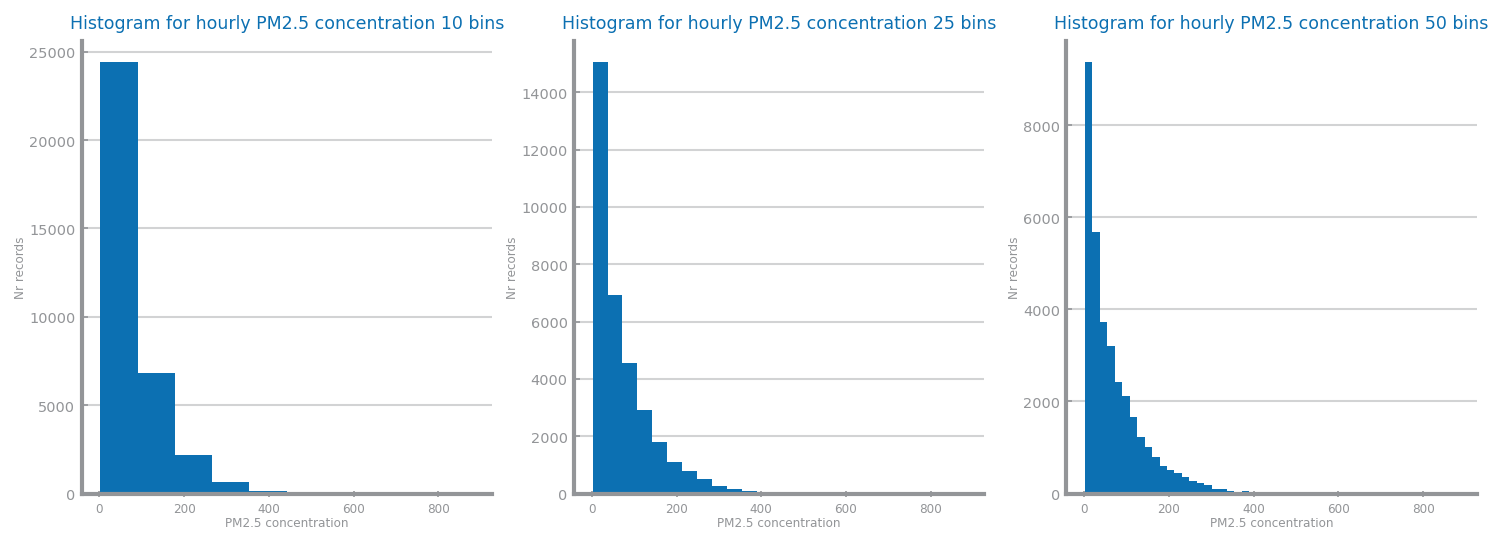

In [164]:
bins = (10, 25, 50)
fig, axs = plt.subplots(1, len(bins), figsize=(len(bins)*HEIGHT, HEIGHT))
for j in range(len(bins)):
  axs[j].set_title(f'Histogram for hourly PM2.5 concentration {bins[j]} bins')
  axs[j].set_xlabel('PM2.5 concentration')
  axs[j].set_ylabel('Nr records')
  axs[j].hist(data[target].groupby(time_var).mean(), bins=bins[j])
plt.show()

Looking at the histogram, it is clear that the distribution is not normal, looks more like an exponential one.

Note the importance of creating the histogram for the most adequate data granularity, for the task at hands:
- Daily: 
- Weekly:
- Monthly:
- Quarterly:

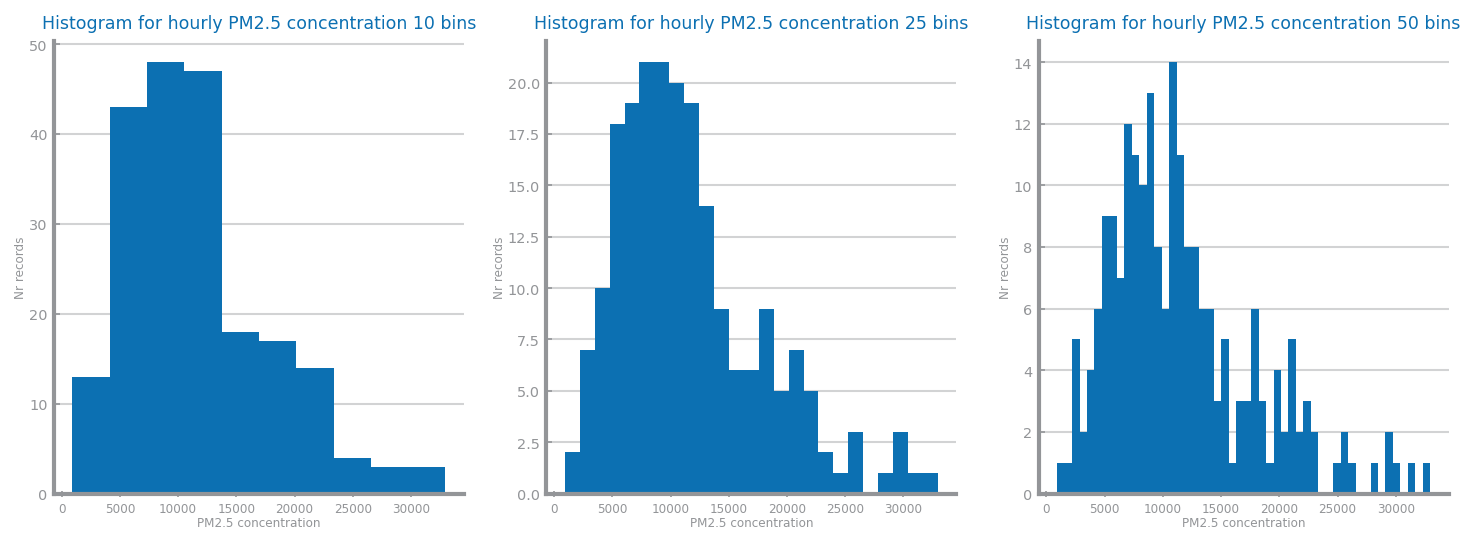

In [165]:
bins = (10, 25, 50)
fig, axs = plt.subplots(1, len(bins), figsize=(len(bins)*HEIGHT, HEIGHT))
for j in range(len(bins)):
  axs[j].set_title(f'Histogram for weekly PM2.5 concentration {bins[j]} bins')
  axs[j].set_xlabel('PM2.5 concentration')
  axs[j].set_ylabel('Nr records')
  axs[j].hist(week_df[target].groupby(time_var).mean(), bins=bins[j])
plt.show()

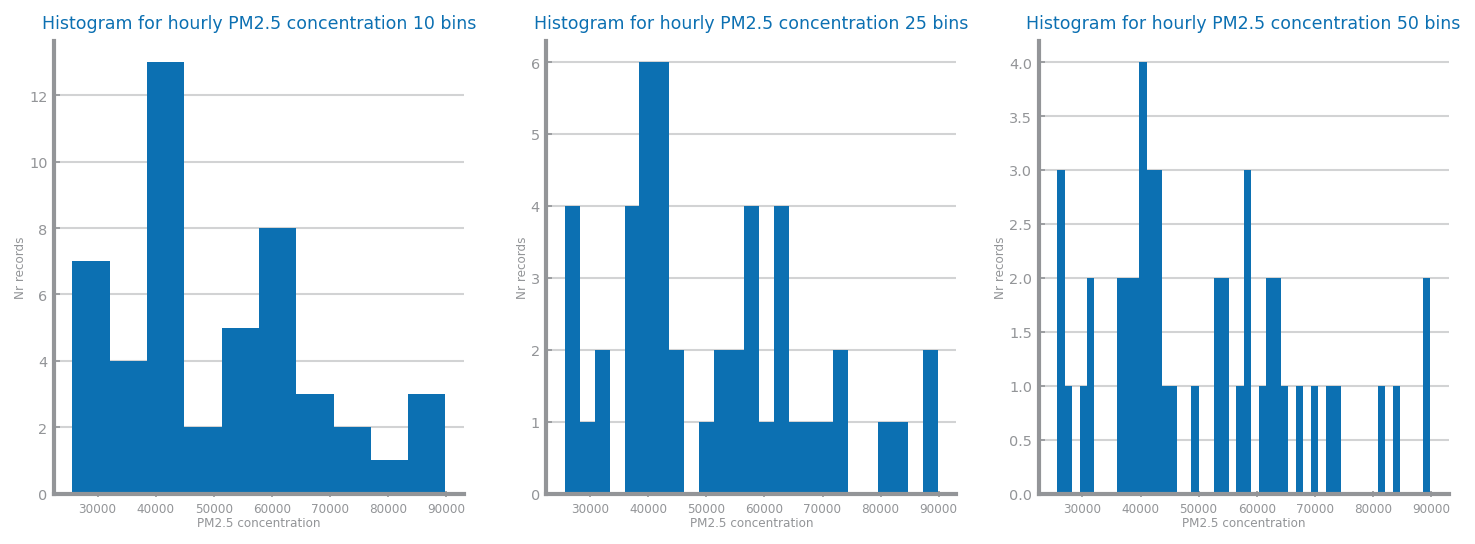

In [166]:
bins = (10, 25, 50)
fig, axs = plt.subplots(1, len(bins), figsize=(len(bins)*HEIGHT, HEIGHT))
for j in range(len(bins)):
  axs[j].set_title(f'Histogram for hourly PM2.5 concentration {bins[j]} bins')
  axs[j].set_xlabel('PM2.5 concentration')
  axs[j].set_ylabel('Nr records')
  axs[j].hist(month_df[target].groupby(time_var).mean(), bins=bins[j])
plt.show()

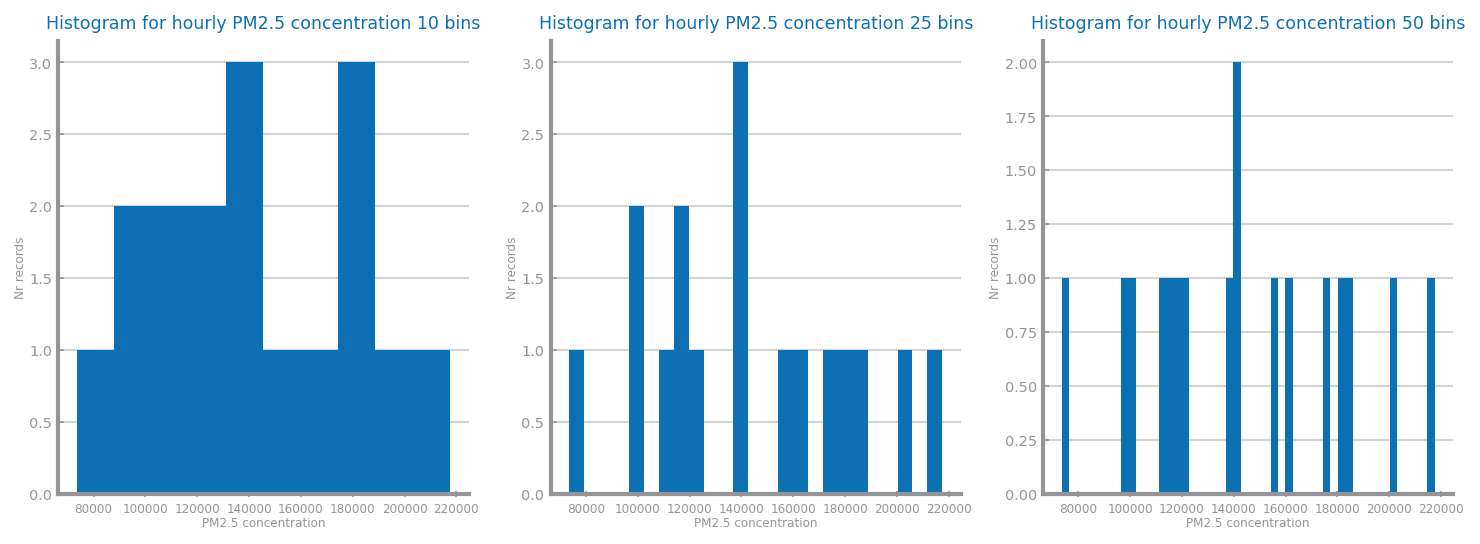

In [167]:
bins = (10, 25, 50)
fig, axs = plt.subplots(1, len(bins), figsize=(len(bins)*HEIGHT, HEIGHT))
for j in range(len(bins)):
  axs[j].set_title(f'Histogram for hourly PM2.5 concentration {bins[j]} bins')
  axs[j].set_xlabel('PM2.5 concentration')
  axs[j].set_ylabel('Nr records')
  axs[j].hist(quarter_df[target].groupby(time_var).mean(), bins=bins[j])
plt.show()

### Data Stationarity

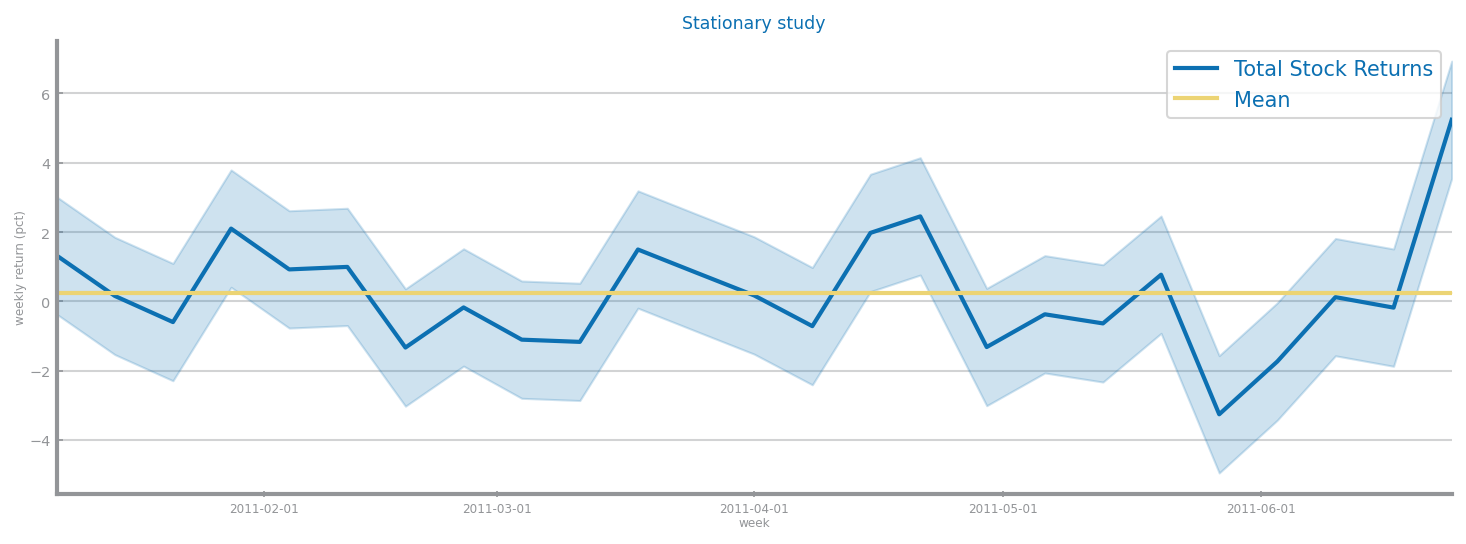

In [19]:
dt_series = Series(data[target].groupby(time_var).mean())

mean_line = Series(ones(len(dt_series.values)) * dt_series.mean(), index=dt_series.index)
series = {'Total Stock Returns': dt_series, 'Mean': mean_line}
plt.figure(figsize=(3*HEIGHT, HEIGHT))
plot_series(series, x_label='week', y_label='weekly return (pct)', title='Stationary study', show_std=True)
plt.show()

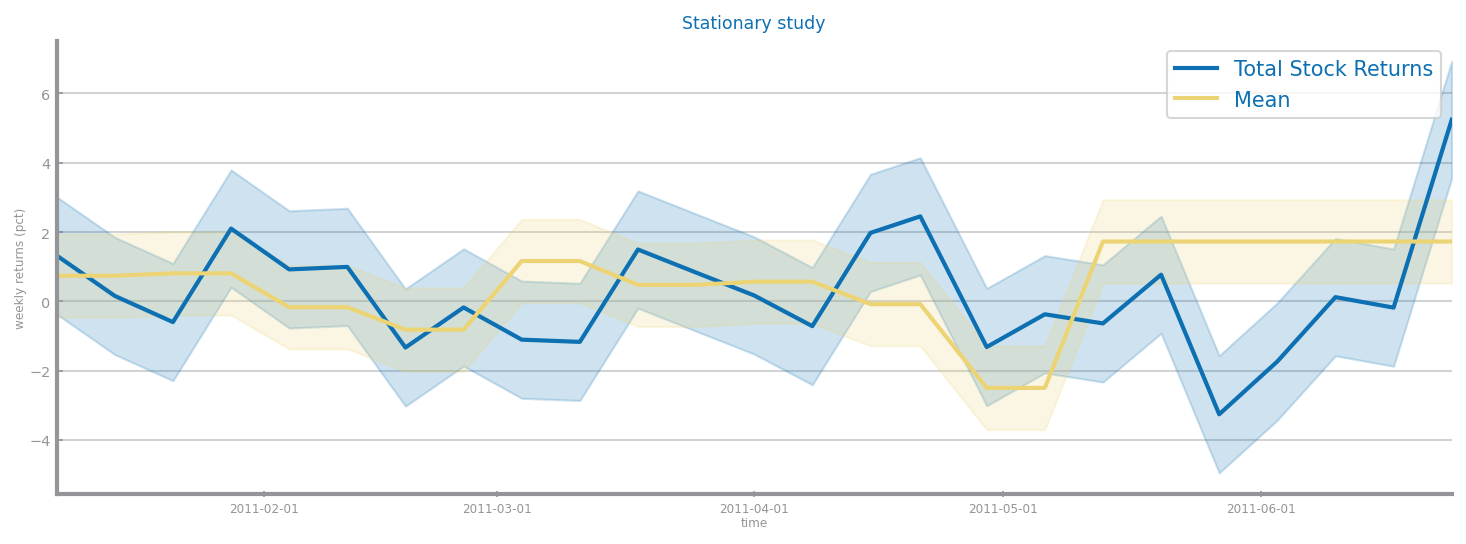

In [20]:
BINS = 10
line = []
n = len(dt_series)
for i in range(BINS):
    b = dt_series[i*n//BINS:(i+1)*n//BINS]
    mean = [b.mean()] * (n//BINS)
    line += mean
line += [line[-1]] * (n - len(line))
mean_line = Series(line, index=dt_series.index)
series = {'Total Stock Returns': dt_series, 'Mean': mean_line}
plt.figure(figsize=(3*HEIGHT, HEIGHT))
plot_series(series, x_label='time', y_label='weekly returns (pct)', title='Stationary study', show_std=True)
plt.show()